In [2]:
!ls -l corpora

total 15144
-rw-rw-r--@ 1 alex  staff  3252510 Jun  1  2020 AnnaKarenina.txt
-rw-rw-r--@ 1 alex  staff  1267920 Jun  1  2020 WarAndPeace.txt
-rw-rw-r--@ 1 alex  staff  3226634 Jun  1  2020 WarAndPeaceEng.txt


In [210]:
import numpy as np
import random
import re 
import pandas as pd

from collections import Counter, defaultdict
from operator import itemgetter
from tqdm.notebook import tqdm

import fastwer
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Базовый частотный метод по Шерлоку Холмсу

In [193]:
def load_text(path):
    with open(path, "r") as f:
        return f.read()

def has_cyrillic(text):
    return bool(re.search('[а-яА-Я]', text))

def letter_filter(letter, cyrillic=False, skip_aplha_check=False):
    if skip_aplha_check:
        if letter.isspace():
            return False
    elif not letter.isalpha():
        return False
    
    if cyrillic:        
        return has_cyrillic(letter)
    else:
        return True
    
def sort_by_count(freq):
    return list(reversed(sorted([(count, k) for k, count in freq.items()])))


def letter_freq(text, cyrillic=False, skip_aplha_check=False, count_space=False):
    counter = Counter(text.upper())
    res = {k:count for k, count in counter.items() if letter_filter(k, cyrillic, skip_aplha_check) or (count_space and k == " ")}
    return sort_by_count(res)    

ANNA_TEXT = load_text("corpora/AnnaKarenina.txt")
    
freq = letter_freq(ANNA_TEXT, cyrillic=True)

print(len(freq))
freq

32


[(162409, 'О'),
 (123650, 'Е'),
 (117104, 'А'),
 (98139, 'Н'),
 (93874, 'И'),
 (84639, 'Т'),
 (75124, 'С'),
 (70914, 'Л'),
 (66562, 'В'),
 (56289, 'Р'),
 (48460, 'К'),
 (41632, 'Д'),
 (40527, 'М'),
 (38129, 'У'),
 (34093, 'П'),
 (30444, 'Я'),
 (27853, 'Ь'),
 (26214, 'Ы'),
 (25693, 'Г'),
 (24718, 'Б'),
 (23858, 'Ч'),
 (23121, 'З'),
 (16020, 'Ж'),
 (14862, 'Й'),
 (12068, 'Ш'),
 (10986, 'Х'),
 (8812, 'Ю'),
 (5019, 'Э'),
 (4054, 'Щ'),
 (3993, 'Ц'),
 (1781, 'Ф'),
 (412, 'Ъ')]

In [66]:
ALPHABET = set(map(itemgetter(1), freq))

" ".join(list(sorted(ALPHABET)))

'А Б В Г Д Е Ж З И Й К Л М Н О П Р С Т У Ф Х Ц Ч Ш Щ Ъ Ы Ь Э Ю Я'

**Возьмём в качестве корпуса Анну Каренину. В тексте есть все буквы русского алфавита кроме "Ё", инетресно это Толстой так писал или вырезали при оцифровке? Полагаю второе**

In [134]:
ANNA_SENTENCES = nltk.tokenize.sent_tokenize(ANNA_TEXT)

def sample_sentence(sentences, count=1, min_length=40, concat=1):
    res = []
    while len(res) < count:
        item = []
        while len(item) < concat:
            sentence = random.choice(sentences)
            if len(sentence) >= min_length:
                item.append(sentence)
                
        res.append(" ".join(item))

    return res
    
sample_sentence(ANNA_SENTENCES, 5, concat=2)

['Они все глядели на него, но никто ничего не говорил до тех пор, пока вышедший на дорогу высокий старик со сморщенным и безбородым лицом, в овчинной куртке, не обратился к нему. Она знала, что значит и за какие деньги приобретается эта простота.',
 'Еще по звуку легких шагов на лестнице он почувствовал ее приближение, и, хотя он был доволен своею речью, ему стало страшно за предстоящее объяснение…\n\n\n\n\n\nIX\n\n\n\n\nАнна шла, опустив голову и играя кистями башлыка. – умоляющим голосом заговорил он в отворенную дверь.',
 'Болото высохло, и дупелей совсем не было. Купец больше не давал денег, тем более что в эту зиму Дарья Александровна, в первый раз прямо заявив права на свое состояние, отказалась расписаться на контракте в получении денег за последнюю треть леса.',
 'Вслед за ним пришел лакей от княгини Бетси и принес Анне записку:\n\n«Я послала к Алексею узнать об его здоровье, и он мне пишет, что здоров и цел, но в отчаянии». – смеясь, обратилась Бетси к входившей в ее ложу даме

In [55]:
def show_char_range(a, b):
    return " ".join(map(chr, range(a, b)))

show_char_range(ord(u"\u3040"), ord(u"\u309f")) # Japanese Hiragana

'\u3040 ぁ あ ぃ い ぅ う ぇ え ぉ お か が き ぎ く ぐ け げ こ ご さ ざ し じ す ず せ ぜ そ ぞ た だ ち ぢ っ つ づ て で と ど な に ぬ ね の は ば ぱ ひ び ぴ ふ ぶ ぷ へ べ ぺ ほ ぼ ぽ ま み む め も ゃ や ゅ ゆ ょ よ ら り る れ ろ ゎ わ ゐ ゑ を ん ゔ ゕ ゖ \u3097 \u3098 ゙ ゚ ゛ ゜ ゝ ゞ'

In [56]:
show_char_range(ord(u"\u30a0"), ord(u"\u30ff")) # Japanese Katakana

'゠ ァ ア ィ イ ゥ ウ ェ エ ォ オ カ ガ キ ギ ク グ ケ ゲ コ ゴ サ ザ シ ジ ス ズ セ ゼ ソ ゾ タ ダ チ ヂ ッ ツ ヅ テ デ ト ド ナ ニ ヌ ネ ノ ハ バ パ ヒ ビ ピ フ ブ プ ヘ ベ ペ ホ ボ ポ マ ミ ム メ モ ャ ヤ ュ ユ ョ ヨ ラ リ ル レ ロ ヮ ワ ヰ ヱ ヲ ン ヴ ヵ ヶ ヷ ヸ ヹ ヺ ・ ー ヽ ヾ'

**Переставлять буквы скучно, надо закодировать чем-нить эдаким, например японской слоговой азбукой. Возьму катакану, люблю когда в иероглифах короткие прямые линии и острые углы.**

In [250]:
katakana = list(map(chr, range(ord(u"\u30a0"), ord(u"\u30ff"))))

def clean_sentence(text, alphabet):
    res = []
    
    for c in text:
        if c in alphabet or c == " ":
            res.append(c)
            
    return "".join(res)        

def cypher_chars(text, cypher):
    return "".join(map(lambda c: cypher[c], text))

def encrypt(texts, alphabet, replacement_chars):    
    original = []
    enc = []
    cypher_alpha = []
    
    for text in texts:        
        text = text.upper()
        text = clean_sentence(text, alphabet)
        
        random.shuffle(replacement_chars)    
        cypher = {c:replacement_chars[i]  for i, c in enumerate(alphabet) }
        cypher[" "] = " "
        enc_text = "".join(map(lambda c: cypher[c], text))
        enc_text = cypher_chars(text, cypher)
        
        original.append(text)
        enc.append(enc_text)
        cypher_alpha.append(replacement_chars[0:len(alphabet)])
    
    return original, enc, cypher_alpha
    
    
senteces = sample_sentence(ANNA_SENTENCES, 2, concat=3)
original, encrypted, _ = encrypt(senteces, ALPHABET, katakana)
original, encrypted

(['И ЭТОТ ИДЕАЛ ЕГО ГЕРОЙ ЛЕВИН НАХОДИТ В НАРОДНОЙ ЖИЗНИ НАПРОТИВ ОН ВЕСЕЛ БЫВАЕТ ЗА ГРАНИЦЕЙ НО НИКОГДА ТАК КАК ЗДЕСЬ  ЕСЛИ ХОЧЕШЬ ЗНАТЬ ВСЮ МОЮ ИСПОВЕДЬ В ЭТОМ ОТНОШЕНИИ Я СКАЖУ ТЕБЕ ЧТО В ВАШЕЙ ССОРЕ С СЕРГЕЕМ ИВАНЫЧЕМ Я НЕ БЕРУ НИ ТОЙ НИ ДРУГОЙ СТОРОНЫ',
  'ПРИ ЭТИХ СЛОВАХ ЛИЦО ЛЕВИНА ВДРУГ ПРОСИЯЛО УЛЫБКОЙ ТОЮ КОТОРАЯ БЛИЗКА К СЛЕЗАМ УМИЛЕНИЯ ЗАД БЫЛ НЕМНОГО СВИСЛЫЙ И В НОГАХ ПЕРЕДНИХ И ОСОБЕННО ЗАДНИХ БЫЛА ЗНАЧИТЕЛЬНАЯ КОСОЛАПИНА  ЗАТЕМ ВИДНО И НЕ ЖЕНИЛСЯ И НИКОГДА НЕ СОБИРАЛСЯ'],
 ['テ ソミヹミ テヂバヤケ バボヹ ボバペヹヵ ケバキテマ マヤッヹヂテミ キ マヤペヹヂマヹヵ ヅテデマテ マヤャペヹミテキ ヹマ キバドバケ シイキヤバミ デヤ ボペヤマテズバヵ マヹ マテギヹボヂヤ ミヤギ ギヤギ デヂバドヨ  バドケテ ッヹーバザヨ デマヤミヨ キドヲ ョヹヲ テドャヹキバヂヨ キ ソミヹョ ヹミマヹザバマテテ ヰ ドギヤヅン ミバシバ ーミヹ キ キヤザバヵ ドドヹペバ ド ドバペボババョ テキヤマイーバョ ヰ マバ シバペン マテ ミヹヵ マテ ヂペンボヹヵ ドミヹペヹマイ',
  'ボピヱ ゼポヱヾ ヌヒイウグヾ ヒヱクイ ヒヴウヱフグ ウヰピッキ ボピイヌヱエヒイ ッヒノヨェイコ ポイズ ェイポイピグエ ヨヒヱダェグ ェ ヌヒヴダグビ ッビヱヒヴフヱエ ダグヰ ヨノヒ フヴビフイキイ ヌウヱヌヒノコ ヱ ウ フイキグヾ ボヴピヴヰフヱヾ ヱ イヌイヨヴフフイ ダグヰフヱヾ ヨノヒグ ダフグネヱポヴヒヅフグエ ェイヌイヒグボヱフグ  ダグポヴビ ウヱヰフイ ヱ フヴ ロヴフヱヒヌエ ヱ フヱェイキヰグ フヴ ヌイヨヱピグヒヌエ'])

In [251]:
def freq_decrypt(texts, freq):    
    letter_freq_order = list(map(itemgetter(1), freq))    
    
    res = []
    for text in texts:
        enc_freq = letter_freq(text, skip_aplha_check=True)
        enc_freq_order =  list(map(itemgetter(1), enc_freq))
        chyper = {cc:letter_freq_order[i] for i, cc in enumerate(enc_freq_order)}
        chyper[" "] = " "
        
        res.append(cypher_chars(text, chyper))
        
    return res

decrypted = freq_decrypt(encrypted, freq)
decrypted

['Н ЭТЕТ НРОИЬ ОДЕ ДОВЕК ЬОЛНА АИЮЕРНТ Л АИВЕРАЕК ХНЯАН АИШВЕТНЛ ЕА ЛОСОЬ БЗЛИОТ ЯИ ДВИАНЩОК АЕ АНМЕДРИ ТИМ МИМ ЯРОСУ  ОСЬН ЮЕЫОЧУ ЯАИТУ ЛСЖ ПЕЖ НСШЕЛОРУ Л ЭТЕП ЕТАЕЧОАНН Й СМИХГ ТОБО ЫТЕ Л ЛИЧОК ССЕВО С СОВДООП НЛИАЗЫОП Й АО БОВГ АН ТЕК АН РВГДЕК СТЕВЕАЗ',
 'ЬРО ХЯОП СИЕУНП ИОЭЕ ИТУОАН УЛРЧБ ЬРЕСОДИЕ ЧИГВМЕЗ ЯЕЮ МЕЯЕРНД ВИОКМН М СИТКНЫ ЧЫОИТАОД КНЛ ВГИ АТЫАЕБЕ СУОСИГЗ О У АЕБНП ЬТРТЛАОП О ЕСЕВТААЕ КНЛАОП ВГИН КАНЙОЯТИШАНД МЕСЕИНЬОАН  КНЯТЫ УОЛАЕ О АТ ЖТАОИСД О АОМЕБЛН АТ СЕВОРНИСД']

**Частотный метод что-то выдаёт, оценим качество с помощью метрики Char Error Rate**

In [143]:
print(fastwer.score(original, decrypted, char_level=True))

36.6858


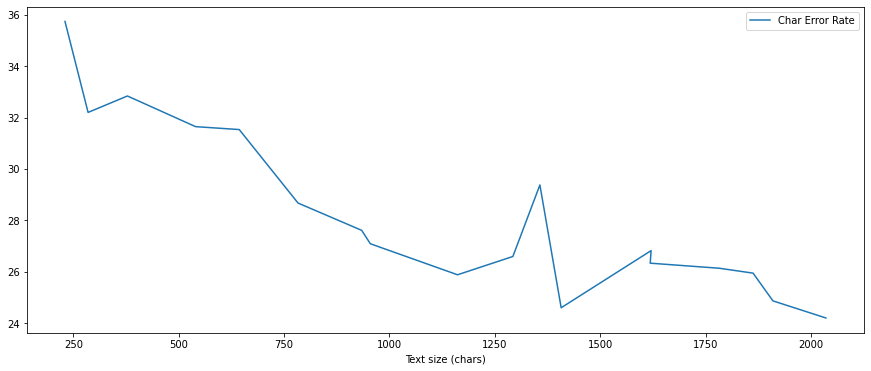

In [170]:
scores = []

for concat in range(2, 20):
    senteces = sample_sentence(ANNA_SENTENCES, 20, concat=concat)
    original, encrypted, _ = encrypt(senteces, ALPHABET, katakana)
    decrypted = freq_decrypt(encrypted, freq)
    score = fastwer.score(original, decrypted, char_level=True)
    
    avg_text_len = np.mean(list(map(len, original)))
    scores.append([avg_text_len, score])
                           
scores = np.array(scores)

plt.figure(figsize=(15,6))
plt.plot(scores[:, 0], scores[:, 1], label="Char Error Rate")
plt.xlabel("Text size (chars)")
plt.legend()
plt.show()

**Зависимость качества от размера загифрованного текста. Как и полагается ошибка уменьшается с ростом размера сообщения**

# 2. Биграмная частотная расшифровка

**Всё таки сделаю по нормальному, уберу из текста всё лишнее кроме русских букв и пробелов, чтобы упростить работу другим функциям**

In [231]:
def clean_text(text):
    res = []
    
    for c in text:
        if c == " " or letter_filter(c, cyrillic=True):
            res.append(c)
            
    return "".join(res)

ANNA_CLEAN_TEXT = clean_text(ANNA_TEXT)
ANNA_CLEAN_TEXT[0:100]

'Анна Каренина один из самых знаменитых романов Льва Толстого начинается ставшей афоризмом фразой Все'

In [232]:
def calc_bigram_freq(text, cyrillic=False, skip_aplha_check=False):
    counter = defaultdict(int)
    
    bigram = []
    for c in text.upper():
        bigram.append(c)

        while len(bigram) > 2:
            bigram.pop(0)

        if len(bigram) == 2:
            counter["".join(bigram)] += 1                          

    return sort_by_count(counter)

bigram_freq = calc_bigram_freq(ANNA_CLEAN_TEXT)

print(len(bigram_freq))
bigram_freq[0:20]

849


[(39425, 'О '),
 (31310, 'Е '),
 (31156, 'А '),
 (30321, 'И '),
 (27158, ' Н'),
 (26942, ' С'),
 (24561, ' В'),
 (24162, 'ТО'),
 (23483, ' П'),
 (22353, ' О'),
 (18580, 'Я '),
 (18511, ' И'),
 (18425, 'НА'),
 (17654, 'СТ'),
 (17330, 'Ь '),
 (16582, 'НЕ'),
 (16334, 'НО'),
 (16156, 'АЛ'),
 (15002, ' К'),
 (14059, 'ГО')]

In [233]:
senteces = sample_sentence(ANNA_SENTENCES, 2, concat=3)
original, encrypted, _ = encrypt(senteces, ALPHABET, katakana)
original, encrypted

(['И КОГДА ОН ВЫШЕЛ ИЗ ВАГОНА В БОЛОГОВЕ ЧТОБЫ ВЫПИТЬ СЕЛЬТЕРСКОЙ ВОДЫ И УВИДАЛ АННУ НЕВОЛЬНО ПЕРВОЕ СЛОВО ЕГО СКАЗАЛО ЕЙ ТО САМОЕ ЧТО ОН ДУМАЛ  ВСКРИКНУЛ ОН УЗНАВ СТЕПАНА АРКАДЬИЧА ОН ХОТЕЛ ПОДХВАТИТЬ УРОНИЛ И С ДОСАДЫ ТОЛКНУЛ НОГОЙ СТОЛ И ПОЗВОНИЛ',
  'К СВОЕЙ СКАЧКЕ ОН МОГ ПОСПЕТЬ НО ЕСЛИ ОН ПОЕДЕТ К БРЯНСКОМУ ТО ОН ТОЛЬКОТОЛЬКО ПРИЕДЕТ И ПРИЕДЕТ КОГДА УЖЕ БУДЕТ ВЕСЬ ДВОР  Я ДУМАЮ  СКАЗАЛ КОНСТАНТИН  ЧТО НИКАКАЯ ДЕЯТЕЛЬНОСТЬ НЕ МОЖЕТ БЫТЬ ПРОЧНА ЕСЛИ ОНА НЕ ИМЕЕТ ОСНОВЫ В ЛИЧНОМ ИНТЕРЕСЕ  ВАРЕНЬКА ЖДЕТ  СКАЗАЛА ОНА ОСТОРОЖНО НАДЕВАЯ НА НЕГО ШЛЯПУ ПО УЛЫБКЕ СЕРГЕЯ ИВАНОВИЧА УВИДАВ ЧТО ЭТО БЫЛО МОЖНО'],
 ['メ ジルトパゼ ル・ ナゴヮモザ メゥ ナゼトル・ゼ ナ コルザルトルナモ ラミルコゴ ナゴチメミダ キモザダミモバキジルカ ナルパゴ メ ッナメパゼザ ゼ・・ッ ・モナルザダ・ル チモバナルモ キザルナル モトル キジゼゥゼザル モカ ミル キゼエルモ ラミル ル・ パッエゼザ  ナキジバメジ・ッザ ル・ ッゥ・ゼナ キミモチゼ・ゼ ゼバジゼパダメラゼ ル・ ドルミモザ チルパドナゼミメミダ ッバル・メザ メ キ パルキゼパゴ ミルザジ・ッザ ・ルトルカ キミルザ メ チルゥナル・メザ',
  'ン ョメシヤス ョンクベンヤ シヷ ヮシニ フショフヤテ・ ヷシ ヤョタレ シヷ フシヤヘヤテ ン ィユキヷョンシヮヨ テシ シヷ テシタ・ンシテシタ・ンシ フユレヤヘヤテ レ フユレヤヘヤテ ンシニヘク ヨオヤ ィヨヘヤテ メヤョ・ ヘメシユ  キ ヘヨヮクル  

In [235]:
def cypher_bigrams(text, chyper):
    res = []
    bigram = []
    
    for c in text:
        bigram.append(c)
    
        if len(bigram) == 2:
            res.append(chyper["".join(bigram)])
            bigram = []
                
    return "".join(res)

def bigram_freq_decrypt(texts, bigram_freq):    
    bigram_freq_order = list(map(itemgetter(1), bigram_freq))
    
    res = []
    for text in texts:
        enc_freq = calc_bigram_freq(text, skip_aplha_check=True)        
        enc_freq_order =  list(map(itemgetter(1), enc_freq))
        chyper = {cc:bigram_freq_order[i] for i, cc in enumerate(enc_freq_order)}        
        res.append(cypher_bigrams(text, chyper))
        
    return res

decrypted = bigram_freq_decrypt(encrypted, bigram_freq)
decrypted

[' ОВ ЕГ ИЕ  НЭТАЛСТЕЙТЬЯ НЕ НЕД ПНОЙ  КРООГ ТПРЧЕОТА АЛ АМ КОВО НЛ  Т ОЛЬВЕОНТА  ОБОМ ВЗАОВЛАМ  В КИВЙ И РИИ КОС ОНИ СЕСКИ РЕМИ КРОИ Е ТЕ ЛОННУТИ ЭДАЬ О Е КА ЖМЕА ГОЮ НЕТАЖЕВААВДЕНАТОИТГОО ЕЛЫ ТЬАКОТКАИНЕНО  ОТВАТРЕ ЧСК ПОРЛОЛЕНОВОА  СО  ОЕЛСЛЕ  Б',
 'ОЛАВИЛЧАГОДИ М П КОВОЕРО АЕ АЛИ АЗЛИЕН ИНАИЛ Н ВОЛДУБОГОВИН  С П К СРАЬ  СРАЬ НАРЕЛ Е КОНАРЕЛ Е У ЧТК ТЬАТНИОБЕ ПРОНАЛМИДЕНО ТТВ РЛЬНЕ ООГАЯЬ ЛОЕДЕЛВАНОАНО ЖЕ О О Т НОЖКИ УПОМ ТОЯ ОВАТ ВЫ М НА ЕОМА ОН Б ПСТТОЯ ДОНЫ ВПОИ ИМПРИЯВ И ТИВАЕТЛЕЗАНОЙ ЛЕ З ОУЖ Н ВНЕ ООГАМ ПСТ П ДДЕОТИ ТОБЕС ОДТОА ЛАЕЙСАСОЫЛНАО  ГРУ МНЕЕРСЛ ТЕГТ РИВ А ВСАСПЕБЫ СЕК СНИАРО ОВАК']

**На биграмах качество хуже при таком же размере зашифрованных сообщений**

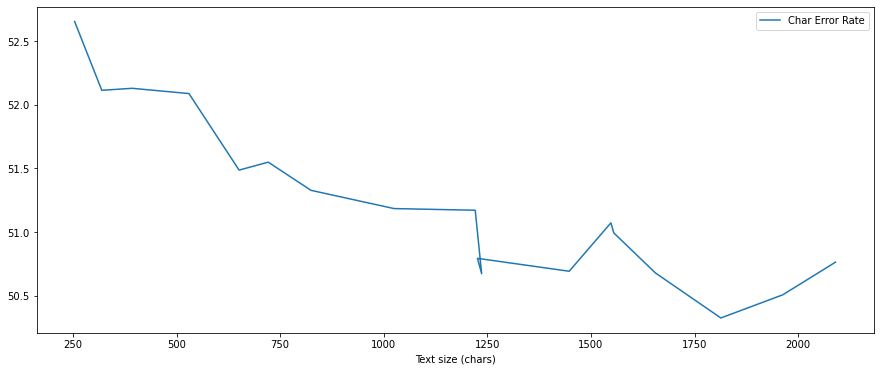

In [237]:
bigram_scores = []

for concat in range(2, 20):
    senteces = sample_sentence(ANNA_SENTENCES, 20, concat=concat)
    original, encrypted, _ = encrypt(senteces, ALPHABET, katakana)
    decrypted = bigram_freq_decrypt(encrypted, bigram_freq)
    score = fastwer.score(original, decrypted, char_level=True)
    
    avg_text_len = np.mean(list(map(len, original)))
    bigram_scores.append([avg_text_len, score])
                           
bigram_scores = np.array(bigram_scores)

plt.figure(figsize=(15,6))
plt.plot(bigram_scores[:, 0], bigram_scores[:, 1], label="Char Error Rate")
plt.xlabel("Text size (chars)")
plt.legend()
plt.show()

# 3. MCMC сэмлирование

**Представим что предложение - это Марковская цепь, тогда большая вероятность следования некой цепочки биграм должна соответствовать тексту со смыслом, а низкая случайному набору символов. Будем жадным перебором искать шифр дающий наибольшую вероятность (правдоподобие) осмысленного текста**

In [303]:
def freq_to_proba(freq):   
    total = sum(map(itemgetter(0), freq))
    return {gram : count / total for count, gram in freq}, total

bigram_proba, total_bigrams = freq_to_proba(bigram_freq)
list(bigram_proba.items())[0:20]

[('О ', 0.023218341930647094),
 ('Е ', 0.018439220947331907),
 ('А ', 0.018348526599651003),
 ('И ', 0.017856774779433114),
 (' Н', 0.015994007105961033),
 (' С', 0.015866799449473532),
 (' В', 0.014464570606433056),
 ('ТО', 0.014229589796532532),
 (' П', 0.013829710172666727),
 (' О', 0.0131642256734497),
 ('Я ', 0.010942214155267546),
 (' И', 0.010901578376111816),
 ('НА', 0.01085093088325105),
 ('СТ', 0.010396870220510938),
 ('Ь ', 0.010206058735779686),
 ('НЕ', 0.00976554333275815),
 ('НО', 0.00961949009753176),
 ('АЛ', 0.009514661565796688),
 (' К', 0.008835042882525497),
 ('ГО', 0.008279687234063854)]

In [378]:
def calc_text_proba(text, mapping, bigram_probas, gram=2):
    decoded = cypher_chars(text, mapping)
    total_proba = 0
    
    for i in range(len(decoded) - gram):
        bigram = decoded[i: i + gram]
        proba = bigram_proba.get(bigram, 1 / total_bigrams)
        total_proba += np.log(proba)
        
    return total_proba
        
def mcmc_decrypt_step(encoded_text, alphabet, alphabet_enc, iterations):
    alphabet_iter = alphabet.copy()
    chyper = {cc: alphabet_iter[i] for i, cc in enumerate(alphabet_enc)}
    log_proba = calc_text_proba(encoded_text, chyper, bigram_proba, gram=2)

    for _ in range(iterations):
        new_alphabet = alphabet_iter[:]
        i, j = np.random.choice(len(new_alphabet), size=2, replace=False)
        new_alphabet[i], new_alphabet[j] = new_alphabet[j], new_alphabet[i]
        new_chyper = {cc: new_alphabet[i] for i, cc in enumerate(alphabet_enc)}
        new_log_proba = calc_text_proba(encoded_text, new_chyper, bigram_proba, gram=2)

        if new_log_proba > log_proba:
            alphabet_iter = new_alphabet
            log_proba = new_log_proba
            chyper = new_chyper

    return chyper, log_proba

def mcmc_decrypt(encoded_text, alphabet, alphabet_enc, bigram_proba, iterations=1000, trials=10):
    best_cypher = None
    best_proba = -np.inf

    for _ in tqdm(range(trials)):
        chyper, log_proba = mcmc_decrypt_step(encoded_text, alphabet, alphabet_enc, iterations)

        if log_proba > best_proba:
            best_proba = log_proba
            best_cypher = chyper
            print(f'Best proba: {best_proba}')

    return best_cypher

In [253]:
senteces = sample_sentence(ANNA_SENTENCES, 1, concat=5)
original, encrypted, cypher_alpha = encrypt(senteces, ALPHABET, katakana)
encrypted

['ヘタノバタ ヅタヨテヘ ユハヘワ ヽドヽタテバーユヰホワ バドスュドォトテバーテ ー ユタュワユド ォ ユテァヽタバテノバタヅ  ヽューノドト ヽバジゲワ ュドゲヅドアーォドジ ュヰヽドヅー ー ヘタヘノドァ ヨテ ゲドスドアーォドジ ァォタズ ユテトーノーズ アドトドヘ ヽドヽ ヨテ バドヅ スタヅーューヘワァジ ヽドヽ ヨテ バドヅ スタヅーューヘワァジ  バヰ ヘテステュワ ホドォドズ ブタォタューヘワ タ ヘテユテ  スューユドォートド タバド ォァヘュジアーォドジ ブタトタォタズ ヽドヽ ユヰホヘタ アタヘテトド ヴーゲーノテァヽー タヘタブバドヘワ ノヘタヘタ トーヲバテテ ー ヅテヲドォヲテテ テズ  タバ スュー ヅバテ ゲォドト テテ バド ヅドゲヰュヽヰ  ァヽドゲドトド バタュホァヘタバ ゲバドジ ノヘタ ヽーヘー スタズヅテヘ ヽヘタ タバ ー タバド']

In [379]:
best_chyper = mcmc_decrypt(
    encrypted[0], 
    list(ALPHABET) + [" "],
    cypher_alpha[0] + [" "], 
    bigram_proba
)

Best proba: -2145.278830692597



In [380]:
decrypted = cypher_chars(encrypted[0], best_chyper)
decrypted

'ТОЧНО МОЖЕТ БЫТЬ КАКОЕНИБУДЬ НАПРАВЛЕНИЕ И БОРЬБА В БЕСКОНЕЧНОМ  КРИЧАЛ КНЯЗЬ РАЗМАГИВАЯ РУКАМИ И ТОТЧАС ЖЕ ЗАПАГИВАЯ СВОЙ БЕЛИЧИЙ ГАЛАТ КАК ЖЕ НАМ ПОМИРИТЬСЯ КАК ЖЕ НАМ ПОМИРИТЬСЯ  НУ ТЕПЕРЬ ДАВАЙ ХОВОРИТЬ О ТЕБЕ  ПРИБАВИЛА ОНА ВСТРЯГИВАЯ ХОЛОВОЙ КАК БУДТО ГОТЕЛА ФИЗИЧЕСКИ ОТОХНАТЬ ЧТОТО ЛИШНЕЕ И МЕШАВШЕЕ ЕЙ  ОН ПРИ МНЕ ЗВАЛ ЕЕ НА МАЗУРКУ  СКАЗАЛА НОРДСТОН ЗНАЯ ЧТО КИТИ ПОЙМЕТ КТО ОН И ОНА'

In [381]:
print("CER =", fastwer.score(original, [decrypted], char_level=True))

CER = 1.1158


**Это работает!**

# 4. Расшифровка

In [186]:
enc_text = "დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ"

**Попробуем частотный метод**

In [195]:
freq_wspace = letter_freq(ANNA_TEXT, cyrillic=True, count_space=True)
freq_decrypt([enc_text], freq_wspace)

['ОЛНА РД РАЫАСО ИЕВЯТНУИДЬ АНА ПЕМСА ИЕВЯТНУИДЬ СОКЛС Ч ЮСЕГЕ ЛЕЕБЖОИАЗ КЕСЕВДЬ НОГКЕ ПВЕМАСТСУ ЛКЕВОО РЛОГЕ РД РЛО ЛЫОНТНА ПВТРАНУИЕ А ПЕНЧМАСО ЯТКЛАЯТНУИДЬ БТНН ЙТ ПЕЛНОЫИОО МОСРОВСЕО ЙТЫТИАО КЧВЛТ ХЕСЗ КЕИОМИЕ З ИАМОГЕ ИО ЕБОЖТШ']

**Не работает**
**Попробуем метод с семплированием**

In [390]:
best_chyper = mcmc_decrypt(
    enc_text, 
    list(ALPHABET) + [" "],
    list(set(enc_text)) + [" "], 
    bigram_proba,
    iterations=10000
)

Best proba: -1306.1918556756543
Best proba: -1276.0871662363497
Best proba: -1234.6544403767348



In [391]:
cypher_chars(enc_text, best_chyper)

'ЕСЛИ ВЫ ВИМИТЕ НОРЖАЛЬНЫЙ ИЛИ ПОДТИ НОРЖАЛЬНЫЙ ТЕКСТ У ЭТОГО СООЧШЕНИЯ КОТОРЫЙ ЛЕГКО ПРОДИТАТЬ СКОРЕЕ ВСЕГО ВЫ ВСЕ СМЕЛАЛИ ПРАВИЛЬНО И ПОЛУДИТЕ ЖАКСИЖАЛЬНЫЙ ЧАЛЛ ЗА ПОСЛЕМНЕЕ ДЕТВЕРТОЕ ЗАМАНИЕ КУРСА БОТЯ КОНЕДНО Я НИДЕГО НЕ ОЧЕШАЮ'

**Это успех! Я думал там будет что-нить про Ковид из первого задания**
**Зальём железом - увеличим количество итераций, может избавимся от небольших ошибок**

In [384]:
best_chyper_max = mcmc_decrypt(
    enc_text, 
    list(ALPHABET) + [" "],
    list(set(enc_text)) + [" "], 
    bigram_proba,
    iterations=50000
)

Best proba: -1347.6965196214285
Best proba: -1290.456607995787
Best proba: -1233.1892783771189



In [385]:
cypher_chars(enc_text, best_chyper_max)

'ЕСЛИ ВЫ ВИМИТЕ НОРДАЛЬНЫЙ ИЛИ ПОЧТИ НОРДАЛЬНЫЙ ТЕКСТ У ЭТОГО СООБЩЕНИЯ КОТОРЫЙ ЛЕГКО ПРОЧИТАТЬ СКОРЕЕ ВСЕГО ВЫ ВСЕ СМЕЛАЛИ ПРАВИЛЬНО И ПОЛУЧИТЕ ДАКСИДАЛЬНЫЙ БАЛЛ ЗА ПОСЛЕМНЕЕ ЧЕТВЕРТОЕ ЗАМАНИЕ КУРСА ХОТЯ КОНЕЧНО Я НИЧЕГО НЕ ОБЕЩАЦ'

**Стало лучше, только пару букв местами надо поменять, но в целом метод рабочий**

In [386]:
best_chyper_max

{'ჲ': 'Т',
 'Ⴙ': 'О',
 'შ': 'В',
 'ნ': 'Ц',
 'Ⴝ': 'Я',
 'ქ': 'Г',
 'ხ': 'М',
 'Ⴇ': 'Ч',
 'ჶ': 'Щ',
 'ე': 'З',
 'დ': 'Е',
 'Ⴒ': 'П',
 'ჵ': 'Л',
 'ჰ': 'Й',
 'Ⴀ': 'Э',
 'Ⴜ': 'Ы',
 'ი': 'Ь',
 'ჳ': 'С',
 'Ⴉ': 'К',
 'Ⴈ': ' ',
 'ჱ': 'Б',
 'ჾ': 'Д',
 'Ⴧ': 'У',
 'ს': 'Н',
 'Ⴍ': 'Р',
 'Ⴃ': 'А',
 'Ⴢ': 'И',
 'Ⴞ': 'Х',
 ' ': 'Ш'}

In [389]:
best_chyper = best_chyper_max.copy()
best_chyper['ჾ'] = 'М'
best_chyper['ხ'] = 'Д'
best_chyper['ნ'] = 'Ю'
cypher_chars(enc_text, best_chyper)

'ЕСЛИ ВЫ ВИДИТЕ НОРМАЛЬНЫЙ ИЛИ ПОЧТИ НОРМАЛЬНЫЙ ТЕКСТ У ЭТОГО СООБЩЕНИЯ КОТОРЫЙ ЛЕГКО ПРОЧИТАТЬ СКОРЕЕ ВСЕГО ВЫ ВСЕ СДЕЛАЛИ ПРАВИЛЬНО И ПОЛУЧИТЕ МАКСИМАЛЬНЫЙ БАЛЛ ЗА ПОСЛЕДНЕЕ ЧЕТВЕРТОЕ ЗАДАНИЕ КУРСА ХОТЯ КОНЕЧНО Я НИЧЕГО НЕ ОБЕЩАЮ'

**Ааа, кажется я понял, Анна Каренина написана ещё дореволюционным алфавитом, там буквы Ё не было, это точно из-за транслитерации**